# PyTorch Facebook Scholarship Challenge

## Final Lab: Classifying flower species

* [Imports](##-Importing-modules-to-use)
* [Data Exploration](##-First,-let's-take-a-look-at-the-data.)
  * [Class Instance Statistics](##-Number-of-Images-Per-Class-Statistics)
  * [Minimum / Maximum Image Sizes](##-Min/Max-Height-&-Width)
  * [Training Dataset Mean / Std. Deviation](##-Training-Mean-&-Standard-Deviation)
* [Datasets & DataLoaders (+ Samplers & Testings)](##-Time-to-create-Datasets-and-DataLoaders)
* [Defining / Loading Model](##-Now,-Let's-Create-Classifier-Models!)
* [Learning Rate Finder](##-Before-the-training,-it's-a-good-practice-find-the-appropriate-learning-rate-range)
* [1Cycle Policy Implementation](##-1Cycle-Policy-Implementation)
* [Training](##-Finally,-it's-time-to-train-the-model!)

---

## [#](#Final-Lab:-Classifying-flower-species) Importing modules to use

In [1]:
import os

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms

from PIL import Image
from collections import Counter, OrderedDict
from tqdm.autonotebook import tqdm
from copy import deepcopy
from decimal import Decimal
from matplotlib.ticker import AutoLocator
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS
from torch.utils.data import DataLoader, WeightedRandomSampler, SequentialSampler, BatchSampler
import torchvision.models as models

fig_bg_color = "lightsteelblue"
plot_bg_color = "slategray"
fontsize = 20

c:\users\0107w\anaconda3\envs\pytorch\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


---

## [#](#Final-Lab:-Classifying-flower-species) First, let's take a look at the data.

### [#](#Final-Lab:-Classifying-flower-species) Number of Images Per Class Statistics

In [2]:
def imageset_stat(root):
    classes = sorted(os.listdir(root), key=(lambda class_num_str: int(class_num_str)))
    counts = []
    for class_num in tqdm(iterable=classes, desc="Counting ...", unit=" Classes"):
        counts.append(len([f for f in os.listdir(os.path.join(root, class_num)) if f.endswith(tuple(IMG_EXTENSIONS))]))

    print("Total:", sum(counts))
    print("Min:", min(counts))
    print("Max:", max(counts))
    print("Mean:", np.mean(counts))
    print("Std:", np.std(counts))

    %matplotlib inline
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5), facecolor=fig_bg_color,
                           subplot_kw=dict(facecolor=plot_bg_color, xlim=(-1, len(classes))))
    ax.set_title("Image Counts per Class", fontsize=fontsize)
    ax.set_xlabel("Image Class", fontsize=fontsize)
    ax.set_ylabel("Count", fontsize=fontsize)
    ax.bar(range(len(classes)), counts, tick_label=classes)
    ax.grid(True, axis='y')
    fig.tight_layout()

train set


Total: 6552
Min: 27
Max: 206
Mean: 64.23529411764706
Std: 35.22593086499847


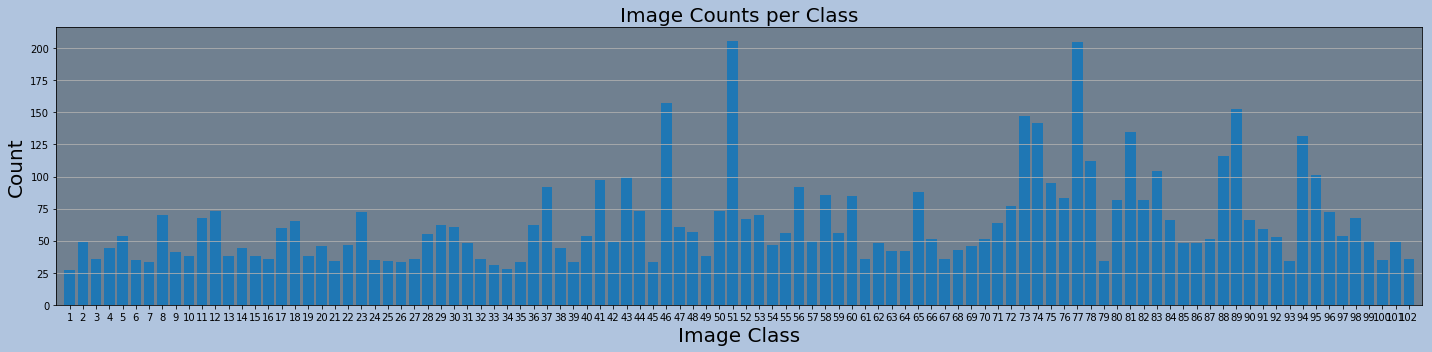

In [3]:
imageset_stat(root='./flower_data/train/')

valid set


Total: 818
Min: 1
Max: 28
Mean: 8.019607843137255
Std: 5.22246353136229


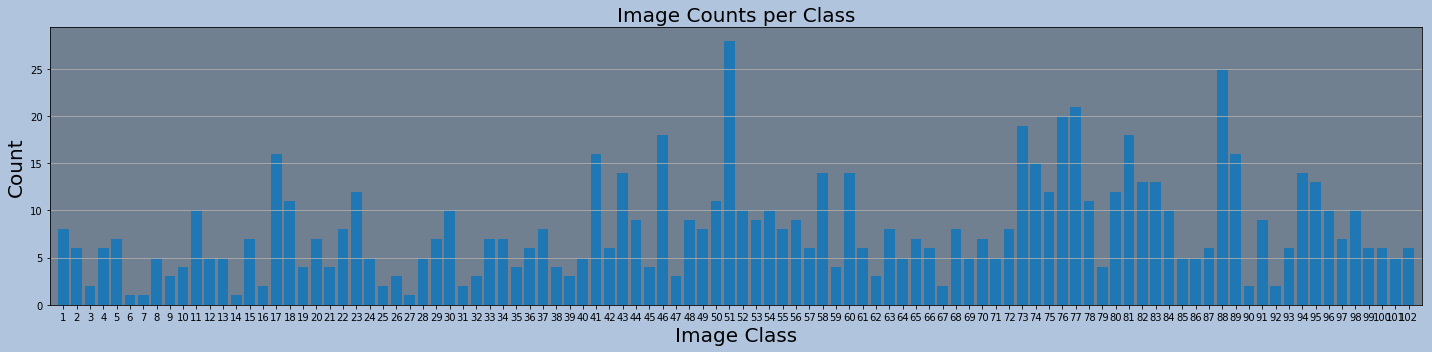

In [4]:
imageset_stat(root='./flower_data/valid/')

**The training set contains unbalanced classes with some classes having more than 100 images while many have less than 50. I will address this problem later through oversampling using weighted random sampling. (For validation set, it does not matter that much, though it still might affect the metrics)**

### [#](#Final-Lab:-Classifying-flower-species) Min/Max Height & Width

In [5]:
def hw_scan(root):
    classes = sorted(os.listdir(root), key=(lambda class_num_str: int(class_num_str)))

    min_height = np.inf
    max_height = -np.inf
    min_width = np.inf
    max_width = -np.inf

    for class_num in tqdm(iterable=classes, desc="Scanning ...", unit=" Classes"):
        class_dir = os.path.join(root, class_num)
        for img in (Image.open(os.path.join(class_dir, f)) for f in os.listdir(class_dir) if f.endswith(tuple(IMG_EXTENSIONS))):
            width, height = img.size

            if height < min_height:
                min_height = height
            elif height > max_height:
                max_height = height

            if width < min_width:
                min_width = width
            elif width > max_width:
                max_width = width

    print("Height:\tMax -", max_height, "\n\tMin -", min_height)
    print()
    print("Width:\tMax -", max_width, "\n\tMin -", min_width)

train set

In [6]:
hw_scan(root='./flower_data/train/')


Height:	Max - 1168 
	Min - 500

Width:	Max - 1024 
	Min - 500


valid set

In [7]:
hw_scan(root='./flower_data/valid/')


Height:	Max - 1137 
	Min - 500

Width:	Max - 892 
	Min - 500


**The minimum height and width are both 500 pixels. Considering this, I'll later crop the images to 500 by 500 and then resize them depending on the model I'll use.**

### [#](#Final-Lab:-Classifying-flower-species) Training Mean & Standard Deviation

In [8]:
def mean_std(root):
    class_paths = [os.path.join(root, class_label) for class_label in sorted(os.listdir(root), key=(lambda class_num_str: int(class_num_str)))]
    
    sums = np.zeros(3)
    total_pixel = 0.
    
    for class_path in tqdm(iterable=class_paths, desc="Calculating Means ...", unit=" Classes"):
        for f in os.listdir(class_path):
            if f.endswith(tuple(IMG_EXTENSIONS)):
                img = np.array(Image.open(os.path.join(class_path, f)), dtype=float) / 255.
                total_pixel += np.prod(img.shape[:2])
                sums += np.sum(img, axis=(0, 1))
    means = sums / total_pixel
    
    var_sums = np.zeros(3)
    
    for class_path in tqdm(iterable=class_paths, desc="Calculating Stds ...", unit=" Classes"):
        for f in os.listdir(class_path):
            if f.endswith(tuple(IMG_EXTENSIONS)):
                img = np.array(Image.open(os.path.join(class_path, f)), dtype=float) / 255.
                var_sums += np.sum((img - means) ** 2, axis=(0, 1))
    stds = np.sqrt(var_sums / total_pixel)
    
    return means, stds

# train_means, train_stds = mean_std(root='./flower_data/train/')
train_means, train_stds = [0.43307249, 0.37494127, 0.2848874], [0.29661228, 0.24537562, 0.26929708]
print("Training set mean per channel:", train_means)
print("Training set std per channel:", train_stds)

Training set mean per channel: [0.43307249, 0.37494127, 0.2848874]
Training set std per channel: [0.29661228, 0.24537562, 0.26929708]


**These mean and std values will be used to normalize the input (Unless specified by the pretrained model)**

---

## [#](#Final-Lab:-Classifying-flower-species) Time to create Datasets and DataLoaders

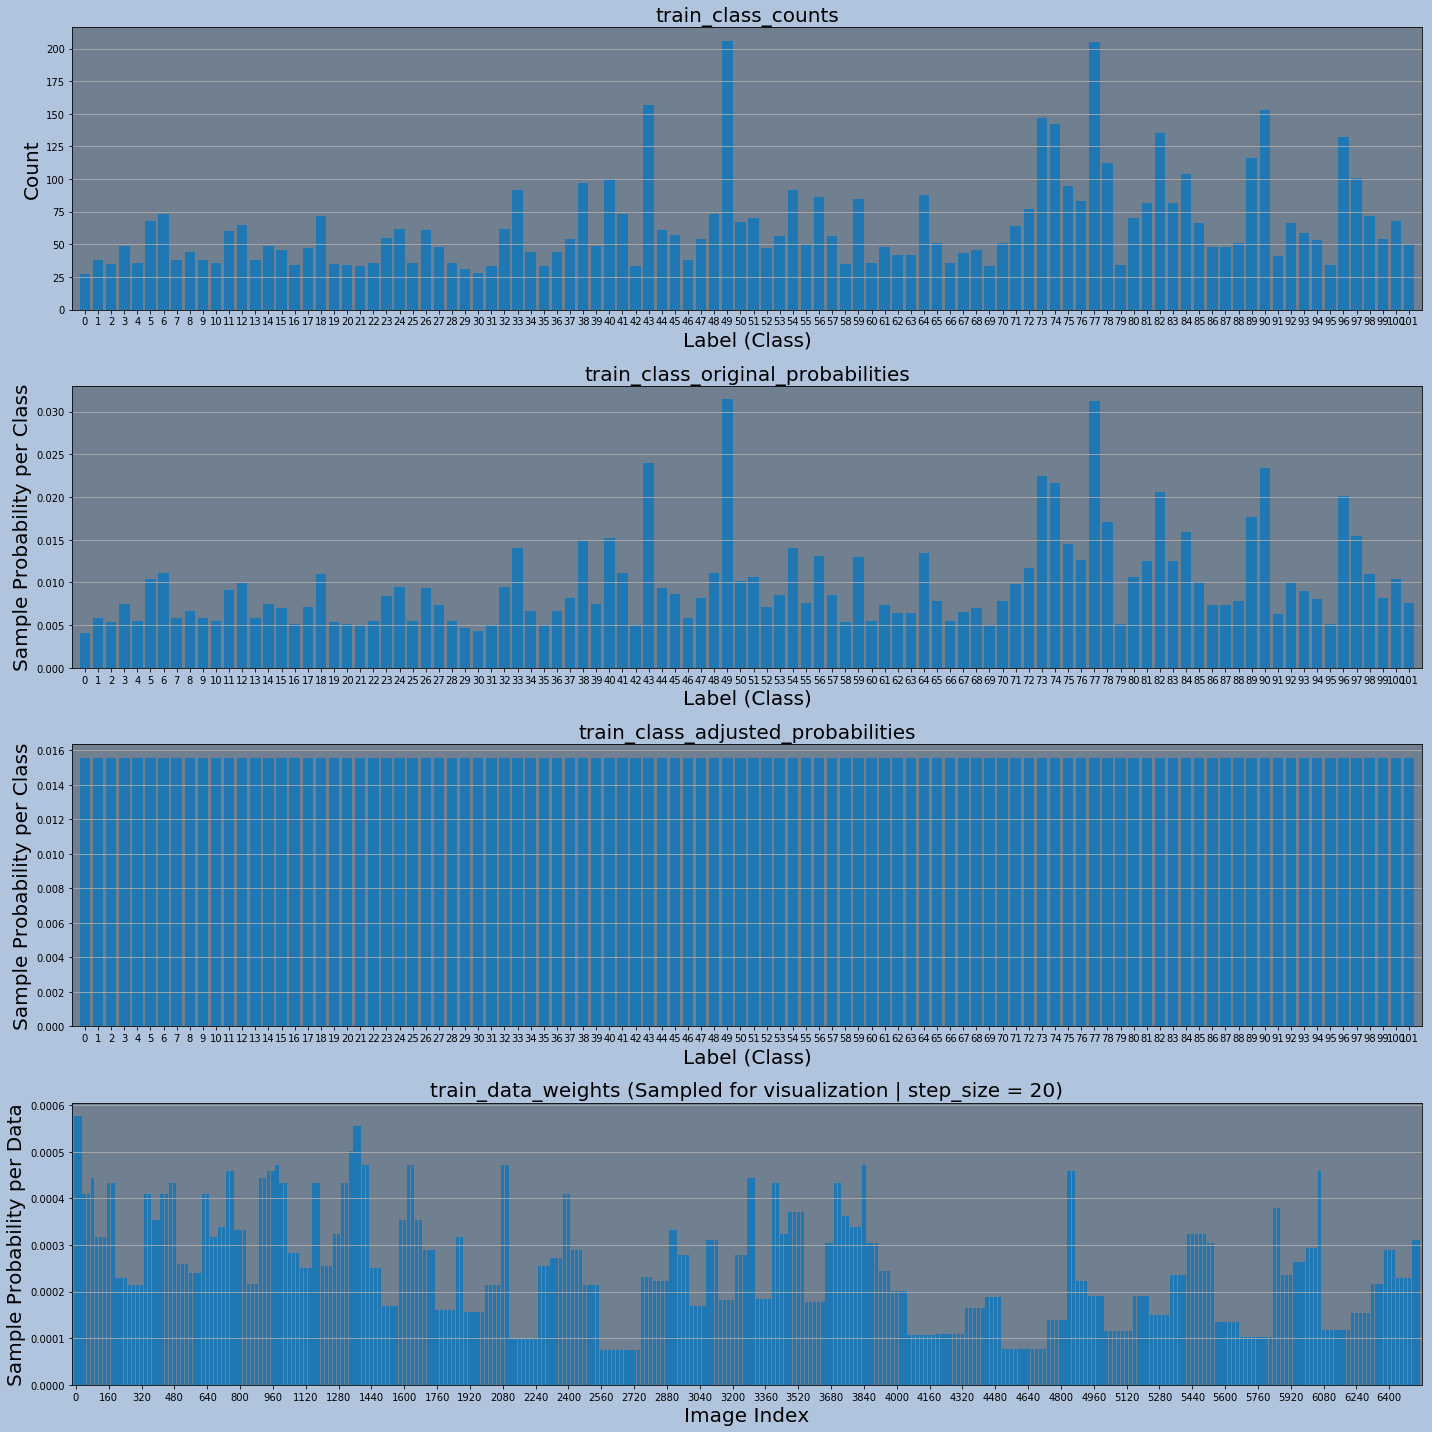

In [9]:
batch_size = 16

# Transformations for the training set and validation set
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=40, translate=(0.1, 0.1), scale=(0.9, 1.3), shear=10),
    transforms.CenterCrop(500),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(train_means, train_stds)
])
transforms_valid = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(500),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(train_means, train_stds)
])

# Base datasets
dataset_train = ImageFolder(root="./flower_data/train/", transform=transforms_train)
dataset_valid = ImageFolder(root="./flower_data/valid/", transform=transforms_valid)

# Calculating the proper weights for oversampling in order to balance the training set
train_class_counter = Counter(class_idx for img_path, class_idx in dataset_train.samples)
train_class_counts = tuple(zip(*sorted(train_class_counter.items(), key=(lambda class_idx_and_count: class_idx_and_count[0]))))[1]
train_class_original_probabilities = torch.tensor(train_class_counts, dtype=torch.float) / sum(train_class_counts)
train_class_adjusted_probabilities = torch.zeros(len(train_class_counts)) + (len(train_class_counts) / sum(train_class_counts))

train_data_weights = torch.ones(len(dataset_train))
prev_idx = 0
for class_idx, end_idx in enumerate(torch.tensor(train_class_counts).cumsum(0)):
    train_data_weights[prev_idx:end_idx] = train_class_adjusted_probabilities[class_idx] / train_class_counts[class_idx]
    prev_idx = end_idx

# Training sampler with the weights(probabilities) calculated for each image + Sequenial sampler for validation
train_sampler = WeightedRandomSampler(weights=train_data_weights, num_samples=len(dataset_train))
valid_sampler = SequentialSampler(dataset_valid)

# DataLoaders to use
train_loader = DataLoader(dataset_train, batch_sampler=BatchSampler(sampler=train_sampler, batch_size=batch_size, drop_last=False))
valid_loader = DataLoader(dataset_valid, batch_sampler=BatchSampler(sampler=valid_sampler, batch_size=batch_size, drop_last=False))

# Visualizing part of the weight calculation
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), facecolor=fig_bg_color,
                        subplot_kw=dict(facecolor=plot_bg_color))

axes[0].set_title('train_class_counts', fontsize=fontsize)
axes[0].set_xlabel("Label (Class)", fontsize=fontsize)
axes[0].set_ylabel("Count", fontsize=fontsize)
axes[0].set_xlim((-1, len(train_class_counts)))
axes[0].bar(range(len(train_class_counts)), train_class_counts, tick_label=range(len(train_class_counts)))
axes[0].grid(True, axis='y')

axes[1].set_title('train_class_original_probabilities', fontsize=fontsize)
axes[1].set_xlabel("Label (Class)", fontsize=fontsize)
axes[1].set_ylabel("Sample Probability per Class", fontsize=fontsize)
axes[1].set_xlim((-1, len(train_class_original_probabilities)))
axes[1].bar(range(len(train_class_original_probabilities)), train_class_original_probabilities, tick_label=range(len(train_class_original_probabilities)))
axes[1].grid(True, axis='y')

axes[2].set_title('train_class_adjusted_probabilities', fontsize=fontsize)
axes[2].set_xlabel("Label (Class)", fontsize=fontsize)
axes[2].set_ylabel("Sample Probability per Class", fontsize=fontsize)
axes[2].set_xlim((-1, len(train_class_adjusted_probabilities)))
axes[2].bar(range(len(train_class_adjusted_probabilities)), train_class_adjusted_probabilities, tick_label=range(len(train_class_adjusted_probabilities)))
axes[2].grid(True, axis='y')

step_size = 20
n_bars = (len(train_data_weights) + step_size - 1) // step_size
n_ticks = min(40, n_bars)
axes[3].set_title(f"train_data_weights (Sampled for visualization | step_size = {step_size})", fontsize=fontsize)
axes[3].set_xlabel("Image Index", fontsize=fontsize)
axes[3].set_ylabel("Sample Probability per Data", fontsize=fontsize)
axes[3].set_xlim(-1, n_bars)
axes[3].bar(range(n_bars), train_data_weights[::step_size])
axes[3].set_xticks(ticks=range(0, n_bars, n_bars // n_ticks))
axes[3].set_xticklabels(labels=[int(tick * step_size) for tick in axes[3].get_xticks()])
axes[3].grid(True, axis='y')

fig.tight_layout()

Checking my implementation

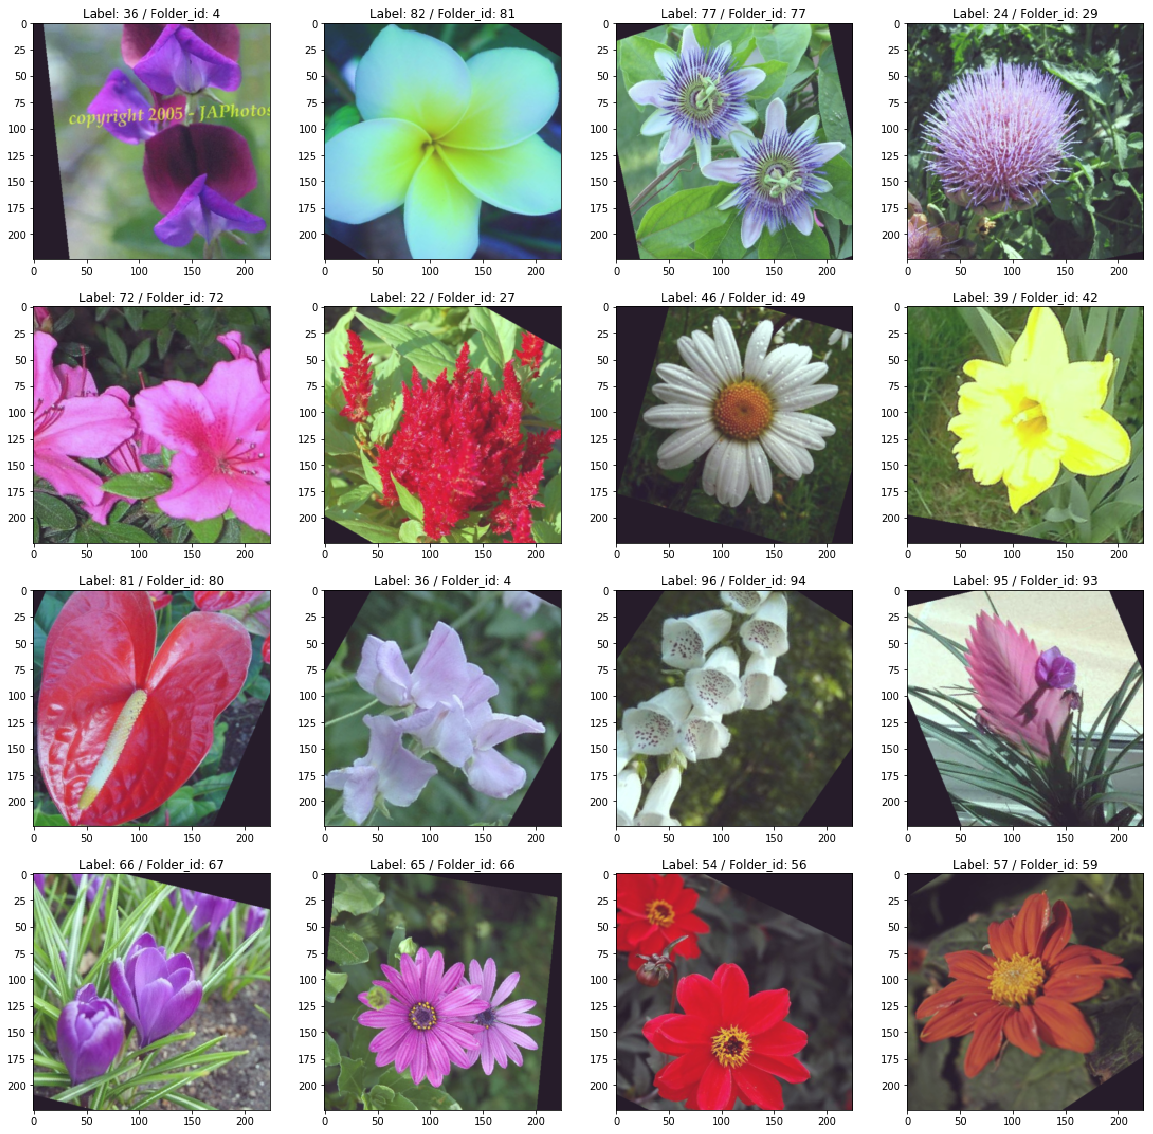

In [10]:
# Images
idx_to_class = dict((v, k) for k, v in dataset_train.class_to_idx.items())

images, labels = next(iter(train_loader))
# images = (images * torch.tensor(train_stds).view(3, 1, 1)).add(torch.tensor(train_means).view(3, 1, 1)).clamp(0, 1)
images = (images * images.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)).add(images.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).clamp(0, 1)

n_cols = 4
desired_n_rows = 4
n_rows = min(int(np.ceil(images.size(0) / 4)), desired_n_rows)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

for idx, ax in enumerate(axes.flatten()):
    if idx < images.size(0):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.set_title(f"Label: {labels[idx].item()} / Folder_id: {idx_to_class[labels[idx].item()]}")
    else:
        ax.axis('off')

Class Frequency

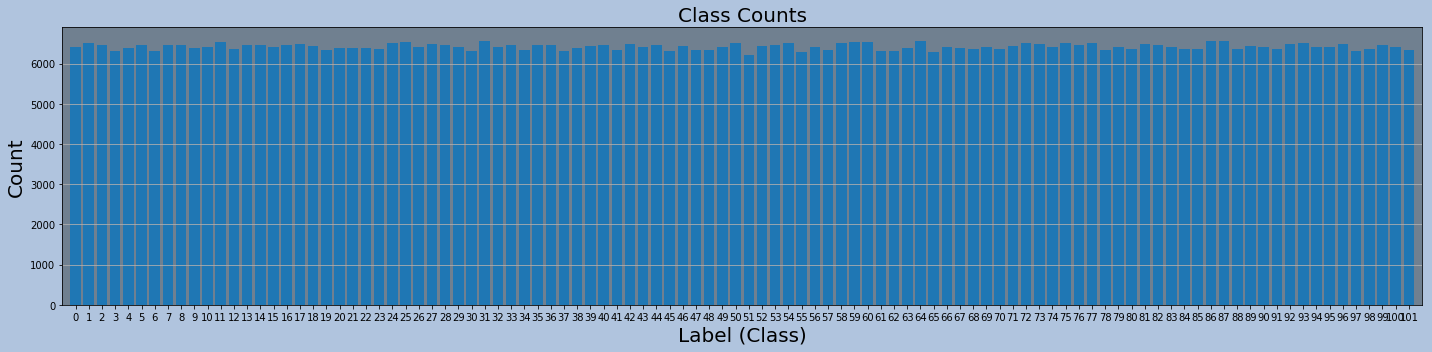

In [11]:
c = Counter()

# This only loads labels, greatly reducing loading time just for this purpose.
cls_idx_loader = DataLoader(tuple(zip(*dataset_train.samples))[1], batch_size=len(dataset_train), sampler=train_sampler)

n_iter = 100
for _ in tqdm(iterable=range(n_iter), desc="Iterating and counting ...", unit=" Iterations"):
    c.update(next(iter(cls_idx_loader)).tolist())

plt.figure(figsize=(20, 5), facecolor=fig_bg_color)
plt.title("Class Counts", fontsize=fontsize)
plt.xlabel("Label (Class)", fontsize=fontsize)
plt.ylabel("Count", fontsize=fontsize)
plt.xlim(-1, len(c))
classes_and_counts = list(zip(*sorted(c.items(), key=(lambda class_and_count: class_and_count[0]))))
plt.bar(range(len(c)), classes_and_counts[1], tick_label=classes_and_counts[0])
plt.gca().set_facecolor(plot_bg_color)
plt.grid(True, axis='y')
plt.tight_layout()

**Seems like the oversampling is working properly! Image preprocessing is pretty much done!**

---

## [#](#Final-Lab:-Classifying-flower-species) Now, Let's Create Classifier Models!

Device Check

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loading a Model

In [13]:
# Using a pretrained model
net = models.densenet169(pretrained=True)
# net.aux_logits = False # For Inception_v3

# Disable gradients for pretrained layers and replace the classifier layer at the end
for param in net.parameters():
    param.requires_grad_(False)
#     param.requires_grad_(True)
net.classifier = nn.Sequential(OrderedDict([("dropout", nn.Dropout()),
                                            ("fc", nn.Linear(in_features=net.classifier.in_features, out_features=102))]))
net.to(device)
print(net)

c:\users\0107w\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

)


In [ ]:
class FlowerClassifier(nn.Module):
    test_time_transforms = transforms.Compose([
        transforms.ToPILImage(),
    ])
    
    class TestTimeDataset(Dataset):
        def __init__(self, tensor, transforms):
            if not torch.is_tensor(tensor):
                raise TypeError("expected a tensor for `tensor`, but got {}".format(type(tensor)))
            if tensor.dim() < 4:
                raise RuntimeError("expected a 4D tensor for `tensor`, but got a {}D tensor".format(tensor.dim()))
            self.data = tensor
            self.transforms = transforms
        def __len__(self):
            return len(self.data)
        def __getitem__(self, index):
            return self.transforms(self.data[index])
        
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        
    def _test_time_augmentation(self, tensor, n=4):
        if not isinstance(n, int):
                raise TypeError("expected an in for `n`, but got {}".format(type(n)))
        if n < 1:
            raise ValueError("value of `n` must be at least 1, but got {}".format(n))
        dataset = self.TestTimeDataset(tensor, self.transforms)
        loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        yield tensor # Original tensor
        for _ in range(n):
            yield next(iter(loader)) # n augmented tensors

---

## [#](#Final-Lab:-Classifying-flower-species) Before the training, it's a good practice find the appropriate learning rate range

**This concept was inspired by the lr_finder in fast.ai, which was based on the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). The code was hugely based on the script [here](https://github.com/davidtvs/pytorch-lr-finder).**

In [14]:
def lr_find(model, optimizer, criterion, train_loader, valid_loader=None, device='cpu', end_lr=10, num_iters=100,
            step_mode="exp", smoothing_factor=0.1, divergence_threshold=5, threshold_mode="rel", live_plot=False):
    """Performs the learning rate range test.
    
    Arguments:
        train_loader (torch.utils.data.DataLoader): the training set data laoder.
        valid_loader (torch.utils.data.DataLoader, optional): if `None` the range test
            will only use the training loss. When given a data loader, the model is
            evaluated after each iteration on that dataset and the evaluation loss
            is used. Note that in this mode the test takes significantly longer but
            generally produces more precise results. Default: None.
        end_lr (float, optional): the maximum learning rate to test. Default: 10.
        num_iters (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        step_mode (str, optional): one of the available learning rate policies,
            linear or exponential ("linear", "exp"). Default: "exp".
        smoothing_factor (float, optional): the loss smoothing factor within the [0, 1[
            interval. Disabled if set to 0, otherwise the loss is smoothed using
            exponential smoothing. Default: 0.05.
        divergence_threshold (int, optional): the test is stopped when the loss surpasses the
            threshold:  diverge_th * best_loss. Default: 5.
        threshold_mode (str, optional): one of ("rel", "abs").
            If "rel", the threshold will be the best_loss * `divergence_threshold`.
            If "abs", the threshold will be the best_loss + `divergence_threshold`. Default: "rel"
        live_plot (bool, optional): whether to display a dynamic plot that shows the progress
            in real time. If `valid_loader` is given, both losses are plotted. Default: True.
    """
    history = {"lr": [], "loss": []}
    
    if not isinstance(num_iters, int):
        raise TypeError("expected int value for num_iter, but got {}".format(type(num_iters)))
    if num_iters < 1:
        return history
    
    if not isinstance(threshold_mode, str):
        raise TypeError('expected str value for threshold_mode, but got {}'.format(type(threshold_mode)))
    if threshold_mode.lower() not in ("abs", "rel"):
        raise ValueError('expected one of (rel, abs), got {}'.format(threshold_mode))
    threshold_mode = threshold_mode.lower()
    
    if not isinstance(step_mode, str):
        raise TypeError('expected str value for step_mode, but got {}'.format(type(step_mode)))
        
    if smoothing_factor < 0 or smoothing_factor >= 1:
        raise ValueError("smoothing_factor is outside the range [0, 1]")
        
    if step_mode.lower() in ("exp", "exponential"):
        ratio = end_lr / optimizer.param_groups[0]['lr']
        gamma = ratio ** (1 / max(num_iters - 1, 1))
        lr_schedule = lr_scheduler.ExponentialLR(optimizer, gamma)
    elif step_mode.lower() in ("lin", "linear"):
        step_size = (end_lr - optimizer.param_groups[0]['lr']) / max(num_iters - 1, 1)
        lr_schedule = lr_scheduler.LambdaLR(optimizer, (lambda epoch: 1 + (step_size * epoch)))
    else:
        raise ValueError("expected one of (exp, linear), got {}".format(step_mode))
    
    init_model_state = deepcopy(model.state_dict())
    init_optimizer_state = deepcopy(optimizer.state_dict())
    
    lr_schedule.step(0)
    lr = lr_schedule.get_lr()[0]
    loss = np.inf
    stat_format = "Learning Rate = {:.2e}, Loss = {:.4f}"
#     stat_tracker = {"Learning Rate": lr_schedule.get_lr()[0], "Loss": np.inf}
    
    model.train()
    iterator = tqdm(iterable=range(num_iters), desc="Iterating ...", unit="epoch")
    iterator.set_postfix_str(stat_format.format(Decimal(lr), loss), refresh=True)
    try:
        if live_plot:
            %matplotlib notebook
            fig, ax = plt.subplots(figsize=(13, 6), facecolor=fig_bg_color)
            ax.set_facecolor(plot_bg_color)
            ax.grid(True)
            if step_mode.lower() in ("exp", "exponential"):
                ax.set_xscale("log")
            else:
                ax.set_xscale("linear")
            ax.set_title("LR Finder", fontsize=fontsize)
            ax.set_xlabel("Learning rate", fontsize=fontsize)
            ax.set_ylabel("Loss", fontsize=fontsize)
            if valid_loader:
                train_losses = []
            
        for iteration in iterator:
            inputs, labels = next(iter(train_loader))
            inputs, labels = inputs.to(device), labels.to(device)

            lr_schedule.step(iteration)

            optimizer.zero_grad()
            
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

            if valid_loader:
                if live_plot:
                    if iteration == 0:
                        train_losses.append(loss.item())
                    else:
                        train_losses.append(smoothing_factor * loss.item() + (1 - smoothing_factor) * train_losses[-1])
                if iteration != 0:
                    valid_iterator.leave = False
                    valid_iterator.close()
                valid_iterator = tqdm(iterable=valid_loader, desc="Validation Iterations", unit="epoch")
                
                model.eval()
                loss = 0
                total_instances = 0
                with torch.no_grad():
                    for inputs, labels in valid_iterator:
                        inputs, labels = inputs.to(device), labels.to(device)
                        loss += criterion(model(inputs), labels).item() * inputs.size(0)
                        total_instances += inputs.size(0)
                        iterator.refresh()
                loss /= total_instances
            else:
                loss = loss.item()

            history['lr'].append(lr_schedule.get_lr()[0])
            lr = history['lr'][-1]

            if iteration == 0:
                best_loss = loss
            else:
                if smoothing_factor > 0:
                    loss = smoothing_factor * loss + (1 - smoothing_factor) * history["loss"][-1]
                if loss < best_loss:
                    best_loss = loss

            history["loss"].append(loss)

            iterator.set_postfix_str(stat_format.format(Decimal(lr), loss), refresh=False)
            
            if live_plot:
                if iteration == 1:
                    if valid_loader:
                        ax.plot(history['lr'], train_losses, color='blue', label='train')
                        ax.plot(history['lr'], history['loss'], color='orange', label='valid')
                        ax.legend()
                    else:
                        ax.plot(history['lr'], history['loss'], color='blue')
                    fig.canvas.draw()
                elif iteration > 1:
                    if valid_loader:
                        ax.lines[0].set_xdata(history['lr'])
                        ax.lines[0].set_ydata(train_losses)
                        ax.lines[1].set_xdata(history['lr'])
                        ax.lines[1].set_ydata(history['loss'])
                    else:
                        ax.lines[0].set_xdata(history['lr'])
                        ax.lines[0].set_ydata(history['loss'])
                    ax.relim()
                    ax.autoscale_view()
                    fig.canvas.draw()

            if threshold_mode == "rel" and loss > divergence_threshold * best_loss:
                print("Stopping early, the loss has diverged.")
                break
            elif loss > divergence_threshold + best_loss:
                print("Stopping early, the loss has diverged.")
                break
                
    except KeyboardInterrupt:
        pass
        
    %matplotlib inline
    model.load_state_dict(init_model_state)
    optimizer.load_state_dict(init_optimizer_state)
    return history

<IPython.core.display.Javascript object>


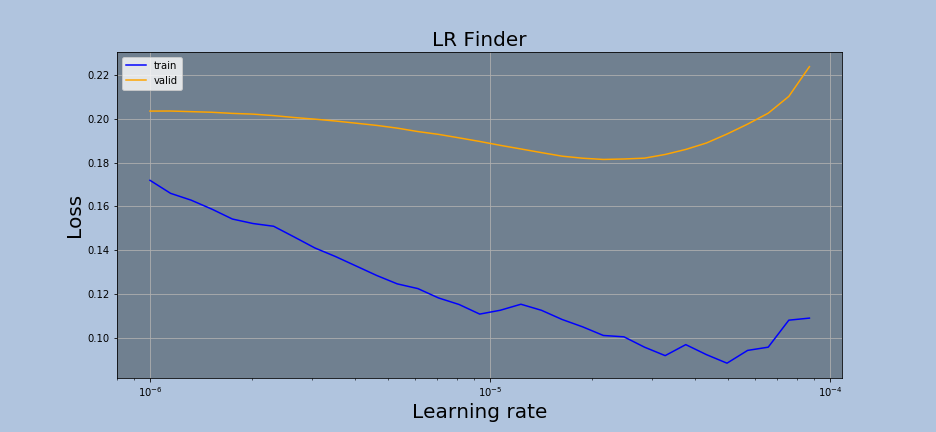

Stopping early, the loss has diverged.
2.1544346900318837e-05


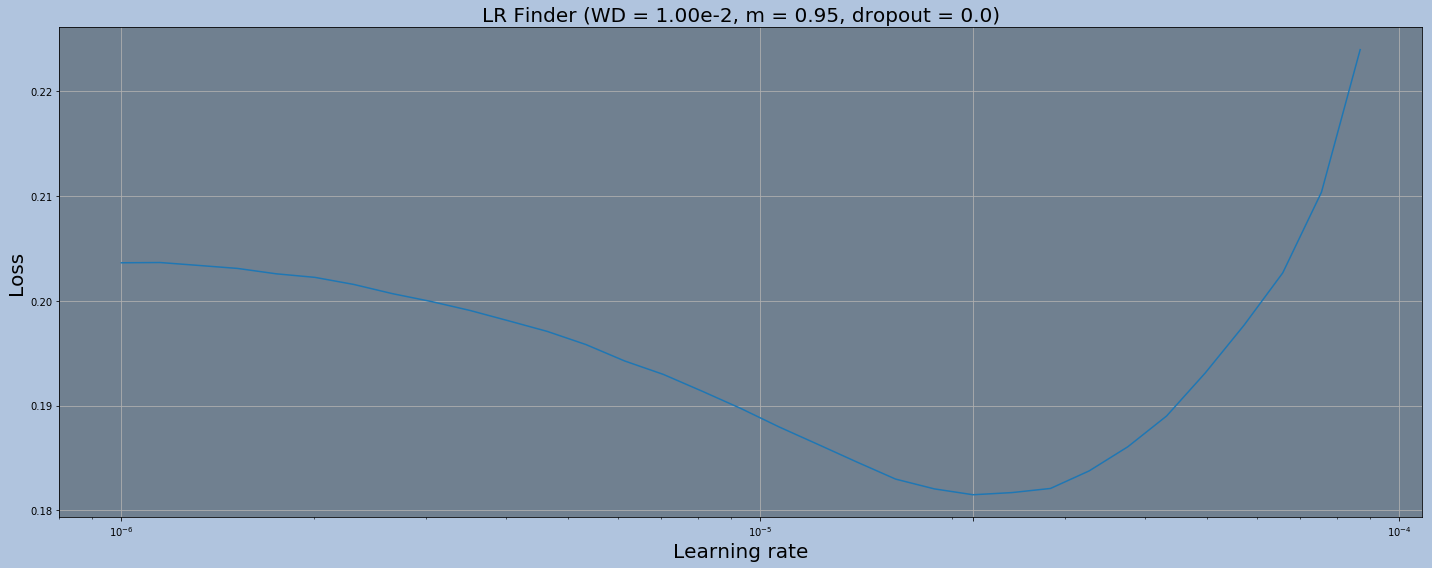

In [34]:
batch_size = 26
weight_decay = 1e-2
momentum = 0.95
dropout = 0.0

train_loader.batch_sampler.batch_size = batch_size
valid_loader.batch_sampler.batch_size = batch_size
net.classifier.dropout.p = dropout

lr_loss_log = lr_find(model=net,
#                       optimizer=optim.SGD(net.parameters(), lr=1e-6, weight_decay=weight_decay, momentum=momentum),
                      optimizer=optim.Adam(net.parameters(), lr=1e-6, betas=(momentum, 0.99), weight_decay=weight_decay),
                      criterion=nn.CrossEntropyLoss(),
                      train_loader=train_loader,
                      valid_loader=valid_loader,
                      device=device,
                      end_lr=1,
                      num_iters=100,
                      step_mode='exp',
                      smoothing_factor=0.05,
                      divergence_threshold=1.2,
                      threshold_mode="rel",
                      live_plot=True)

plt.figure(figsize=(20, 8), facecolor=fig_bg_color)
plt.plot(lr_loss_log['lr'], lr_loss_log['loss'])
plt.gca().set_facecolor(plot_bg_color)
plt.grid(True)
plt.xscale("log")
plt.title("LR Finder (WD = {:.2e}, m = {}, dropout = {})".format(Decimal(weight_decay), momentum, dropout), fontsize=fontsize)
plt.xlabel("Learning rate", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
xlim = plt.gca().get_xlim()
xticks = [tick for tick in plt.gca().get_xticks() if xlim[0] <= tick <= xlim[1]]
if lr_loss_log['lr'][lr_loss_log['loss'].index(min(lr_loss_log['loss']))] not in xticks:
    xticks.append(lr_loss_log['lr'][lr_loss_log['loss'].index(min(lr_loss_log['loss']))])
plt.gca().set_xticks(xticks)
plt.tight_layout()
print(lr_loss_log['lr'][lr_loss_log['loss'].index(min(lr_loss_log['loss']))])

2.1544346900318837e-05


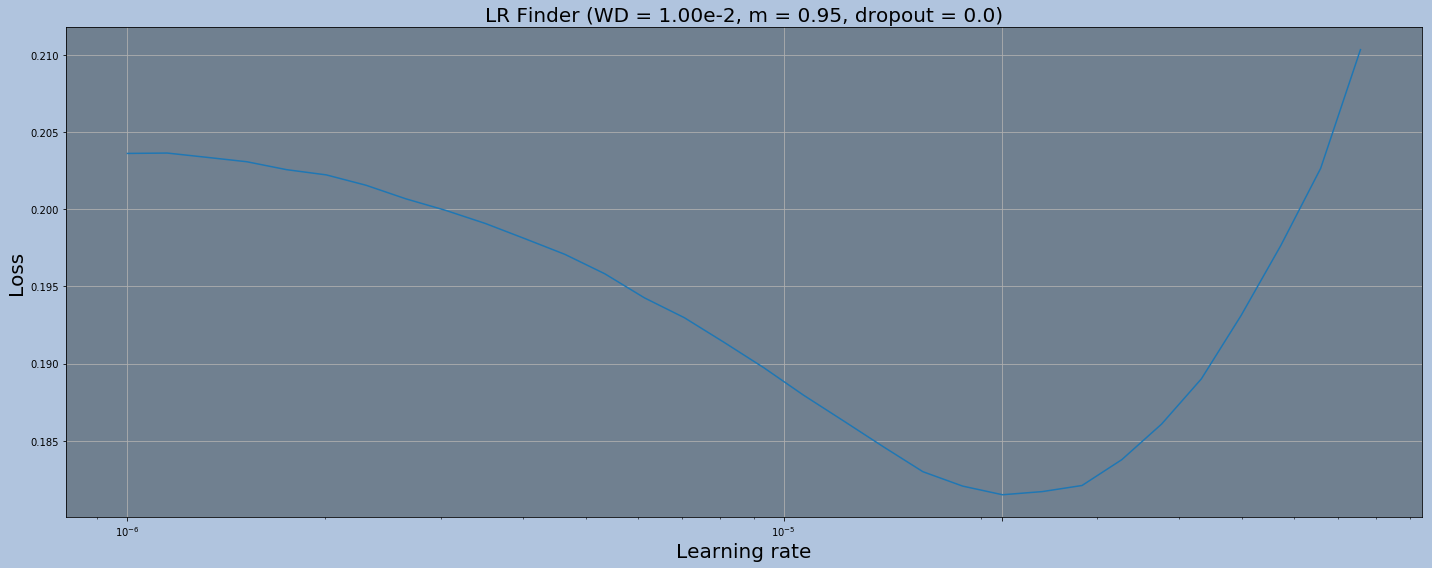

In [35]:
plt.figure(figsize=(20, 8), facecolor=fig_bg_color)
plt.plot(lr_loss_log['lr'][:-1], lr_loss_log['loss'][:-1])
plt.gca().set_facecolor(plot_bg_color)
plt.grid(True)
plt.xscale("log")
plt.title("LR Finder (WD = {:.2e}, m = {}, dropout = {})".format(Decimal(weight_decay), momentum, dropout), fontsize=fontsize)
plt.xlabel("Learning rate", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
xlim = plt.gca().get_xlim()
xticks = [tick for tick in plt.gca().get_xticks() if xlim[0] <= tick <= xlim[1]]
if lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))] not in xticks:
    xticks.append(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])
plt.gca().set_xticks(xticks)
plt.tight_layout()
print(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])

1.873817422860384e-05


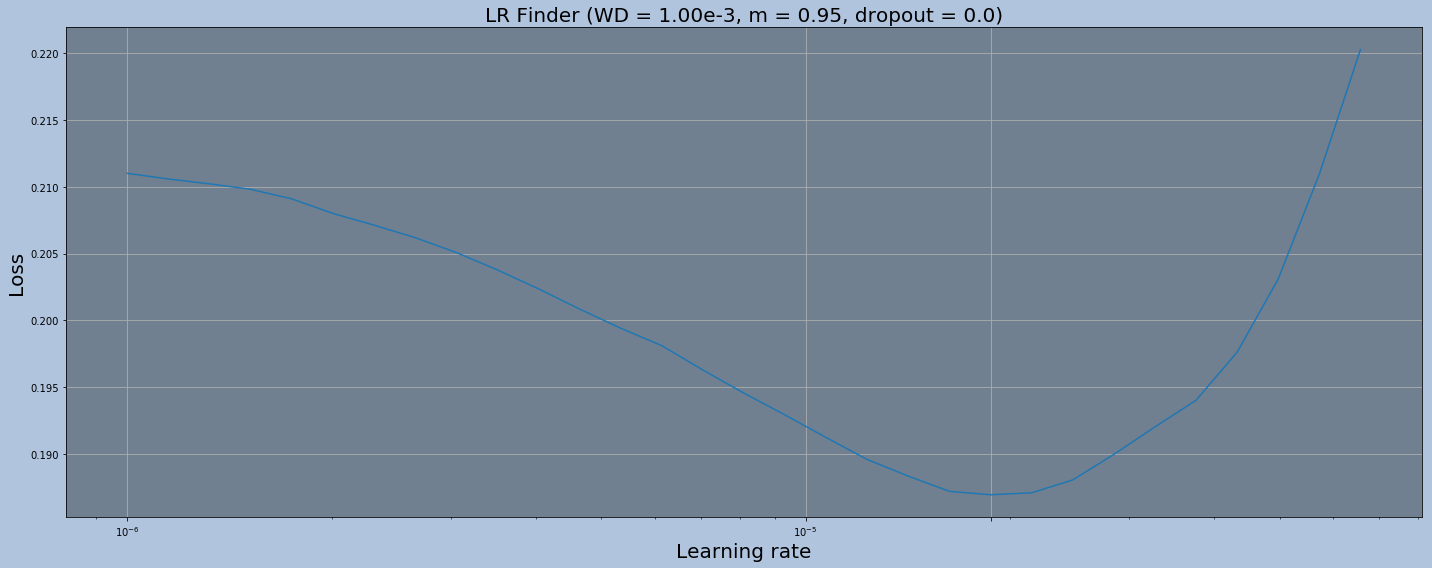

In [31]:
plt.figure(figsize=(20, 8), facecolor=fig_bg_color)
plt.plot(lr_loss_log['lr'][:-1], lr_loss_log['loss'][:-1])
plt.gca().set_facecolor(plot_bg_color)
plt.grid(True)
plt.xscale("log")
plt.title("LR Finder (WD = {:.2e}, m = {}, dropout = {})".format(Decimal(weight_decay), momentum, dropout), fontsize=fontsize)
plt.xlabel("Learning rate", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
xlim = plt.gca().get_xlim()
xticks = [tick for tick in plt.gca().get_xticks() if xlim[0] <= tick <= xlim[1]]
if lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))] not in xticks:
    xticks.append(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])
plt.gca().set_xticks(xticks)
plt.tight_layout()
print(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])

2.477076355991711e-05


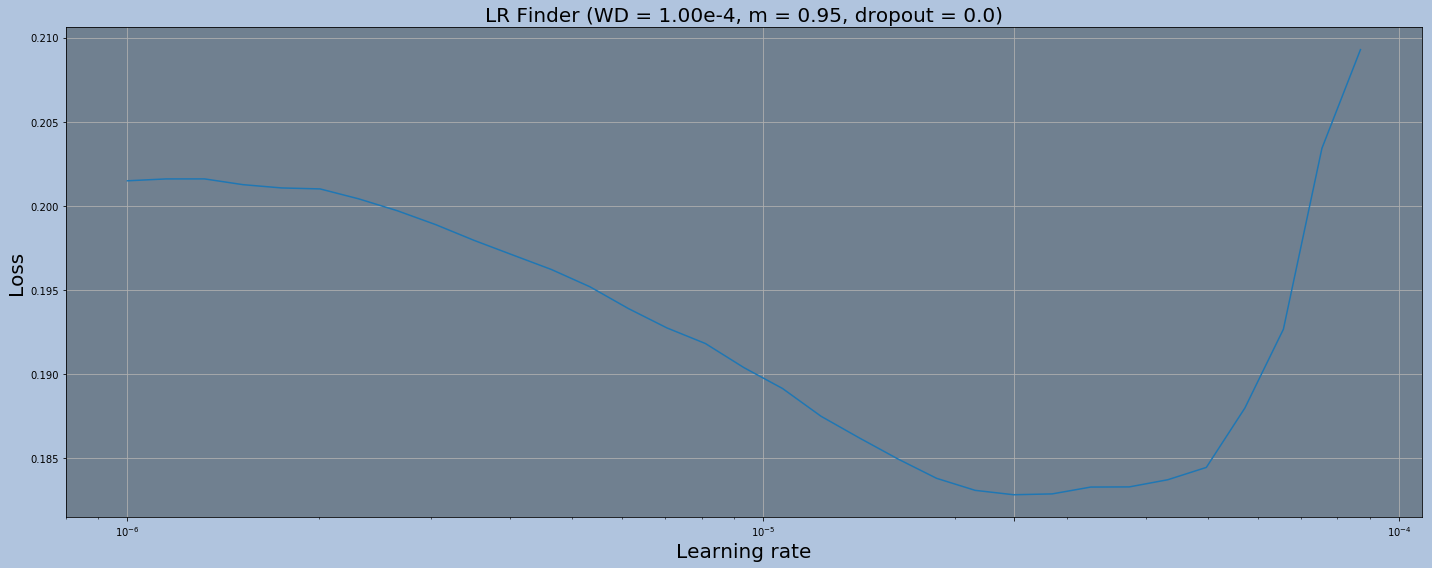

In [33]:
plt.figure(figsize=(20, 8), facecolor=fig_bg_color)
plt.plot(lr_loss_log['lr'][:-1], lr_loss_log['loss'][:-1])
plt.gca().set_facecolor(plot_bg_color)
plt.grid(True)
plt.xscale("log")
plt.title("LR Finder (WD = {:.2e}, m = {}, dropout = {})".format(Decimal(weight_decay), momentum, dropout), fontsize=fontsize)
plt.xlabel("Learning rate", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
xlim = plt.gca().get_xlim()
xticks = [tick for tick in plt.gca().get_xticks() if xlim[0] <= tick <= xlim[1]]
if lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))] not in xticks:
    xticks.append(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])
plt.gca().set_xticks(xticks)
plt.tight_layout()
print(lr_loss_log['lr'][lr_loss_log['loss'][:-1].index(min(lr_loss_log['loss'][:-1]))])

---

## [#](#Final-Lab:-Classifying-flower-species) 1Cycle Policy Implementation
An optimization policy used with SGD. More details [here](https://sgugger.github.io/the-1cycle-policy.html).

In [40]:
class One_Cycle_Policy_LR(lr_scheduler._LRScheduler):
    """Starting with the optimizer's default learning rate, during a single cycle with the given cycle length, linearly
    increases the learning rate to the maximum learning rate specified, then decreases it back to the initial value.
    After the cycle is finished, the learning rate will continue decreasing linearly, decay exponentially, or remain
    constant depending on the mode specified. (The original implementation decreases the learning rate linearly to
    the annihilation)
    
    Optionally, also controls the momentum value; decreasing and increasing it during the cycle.
    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        max_lr (int or float): Maximum learning rate.
        cycle_length (int or float): Number of epochs for the cycle. The value
            can be a float as well.
        total_epochs (int or float): Total number of epochs during the training.
            Used only if `lr_mode_after_cycle` is set to `linear`. Can be a float.
            Otherwise, the value is ignored. Should be greater than `cycle_length`,
            though not strictly prohibited. Default: 0.
        gamma (int or float): Multiplicative factor of learning rate decay. Used only if
            `lr_mode_after_cycle` is set to `exponential`. Ignored for other modes.
            Default: 0.98.
        const_lr (int or float): Constant learning rate value. Used only if `lr_mode_after_cycle`
            is set to 'constant'. Ignored for other modes. Default: 1e-03.
        min_lr (int or float): Minimum learning rate after the cycle. Default: 0.
        lr_mode_after_cycle (str): One of `linear`, `exponential`, `constant`.
            In `linear` mode, the learning rate will continue to decrease linearly
            towards 0 after the cycle is finished until `total_epochs` specified, and it
            will be 0 after it reaches `total_epochs`. In `exponential` mode, the learning
            rate will start decreasing exponentially every epoch after the cycle with decay
            factor `gamma`. In `constant` mode, the learning rate will be set to `const_lr`
            after the cycle and will remain constant. Default: ``linear``.
        min_momentum (int or float): Minimum momentum value within the range [0, 1]. Used only if
            `cyclic_momentum` is ``True``. Default: 0.85.
        cyclic_momentum (bool): Whether to vary the momentum value during the cycle. If
            ``True``, the optimizer must have ``momentum`` parameter (or ``betas`` for Adam)
            and the momentum value will linearly decrease to `min_momentum` and increase back
            to the original value during the cycle. Default: ``False``.
        last_epoch (int or float): The index of last epoch. Can be a float depending on your
            purpose. Default: -1.
    """
    def __init__(self, optimizer, max_lr, cycle_length, total_epochs=0, gamma=0.98, const_lr=3e-3, min_lr=0.,
                 lr_mode_after_cycle="linear", min_momentum=0.85, cyclic_momentum=False, last_epoch=-1):
        if not isinstance(optimizer, optim.Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        
        if not isinstance(max_lr, (int, float)):
            raise TypeError('expected an int or float for `max_lr`, but {} was given'.format(type(max_lr)))
        if max_lr < 0:
            raise ValueError('expected a non-negative value for `max_lr`, but {} was given'.format(max_lr))
        self.max_lr = float(max_lr)
        
        if not isinstance(min_lr, (int, float)):
            raise TypeError('expected an int or float for `min_lr`, but {} was given'.format(type(min_lr)))
        if min_lr < 0:
            raise ValueError('expected a non-negative value for `min_lr`, but {} was given'.format(min_lr))
        self.min_lr = float(min_lr)
        
        if not isinstance(cycle_length, (int, float)):
            raise TypeError('expected an int or float for `cycle_length`, but {} was given'.format(type(cycle_length)))
        if cycle_length < 0:
            raise ValueError('`cycle_length` must be non-negative')
        self.cycle_length = cycle_length
        
        if cyclic_momentum:
            if not isinstance(min_momentum, (int, float)):
                raise TypeError('expected an int or float for `min_momentum`, but {} was given'.format(type(min_momentum)))
            if not 0 <= min_momentum <= 1:
                raise ValueError('expected a value within the range [0, 1] for `min_momentum`, but {} was given'.format(min_momentum))
            self.cyclic_momentum = True
            self.min_momentum = float(min_momentum)
        else:
            self.cyclic_momentum = False
            self.min_momentum = None
        
        if not isinstance(lr_mode_after_cycle, str):
            raise TypeError('expected a str for `lr_mode_after_cycle`, but {} was given'.format(type(lr_mode_after_cycle)))
        self.lr_mode_after_cycle = lr_mode_after_cycle.lower()
        if self.lr_mode_after_cycle == 'linear':
            if not isinstance(total_epochs, (int, float)):
                raise TypeError('expected an int or float for `total_epochs`, but {} was given'.format(type(total_epochs)))
            self.total_epochs = total_epochs
            self.gamma = None
            self.const_lr = None
        elif self.lr_mode_after_cycle == 'exponential':
            if not isinstance(gamma, (int, float)):
                raise TypeError('expected a float for `gamma`, but {} was given'.format(type(gamma)))
            if not 0 <= gamma <= 1:
                raise ValueError('expected a value within the range [0, 1] for `gamma`, but {} was given'.format(gamma))
            self.total_epochs = None
            self.gamma = float(gamma)
            self.const_lr = None
        elif self.lr_mode_after_cycle == 'constant':
            if not isinstance(const_lr, (int, float)):
                raise TypeError('expected a float for `const_lr`, but {} was given'.format(type(const_lr)))
            if const_lr < 0:
                raise ValueError('expected a non-negative value for `const_lr`, but {} was given'.format(const_lr))
            self.total_epochs = None
            self.gamma = None
            self.const_lr = float(const_lr)
        else:
            raise ValueError('expected one of (`linear`, `exponential`, `constant`), but `{}` was given'.format(self.lr_mode_after_cycle))
        
        if last_epoch == -1:
            for i, group in enumerate(optimizer.param_groups):
                if cyclic_momentum:
                    if 'momentum' not in group:
                        if 'betas' not in group:
                            raise KeyError("param 'momentum' or 'betas' is not present "
                                           "in param_groups[{}] of the given optimizer {}".format(i, type(optimizer).__name__))
                        elif self.min_momentum > group['betas'][0]:
                            raise ValueError("first beta value in `betas` of param_groups[{}] of the given optimizer {} "
                                             "is below `min_momentum` given".format(i, type(optimizer).__name__))
                        else:
                            group.setdefault('initial_momentum', group['betas'][0])
                    elif self.min_momentum > group['momentum']:
                        raise ValueError("`momentum` value in param_groups[{}] of the given optimizer {} "
                                         "is below `min_momentum` given".format(i, type(optimizer).__name__))
                    else:
                        group.setdefault('initial_momentum', group['momentum'])
                if self.max_lr < group['lr']:
                    raise ValueError("`lr` value in param_groups[{}] of the given optimizer {} "
                                     "exceeds `max_lr` given".format(i, type(optimizer).__name__))
                else:
                    group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
                if self.max_lr < group['initial_lr']:
                    raise ValueError("`initial_lr` value in param_groups[{}] of the given optimizer {} "
                                     "exceeds `max_lr` given".format(i, type(optimizer).__name__))
                if cyclic_momentum:
                    if 'initial_momentum' not in group:
                        raise KeyError("param 'initial_momentum' is not specified "
                                       "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        if cyclic_momentum:
            self.base_momentums = list(map(lambda group: group['initial_momentum'], optimizer.param_groups))
        else:
            self.base_momentums = None
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch
        
    def get_lr(self):
        if self.last_epoch <= 0:
            return self.base_lrs
        elif self.last_epoch <= self.cycle_length:
            return [self.max_lr + (base_lr - self.max_lr)
                    * abs(-2. * (self.last_epoch / self.cycle_length) + 1)
                    for base_lr in self.base_lrs]
        else:
            if self.lr_mode_after_cycle == 'linear':
                if self.last_epoch < self.total_epochs:
                    return [max(base_lr *
                                (1 - (self.last_epoch - self.cycle_length)
                                 / (self.total_epochs - self.cycle_length)), self.min_lr)
                            for base_lr in self.base_lrs]
                else:
                    return [self.min_lr for base_lr in self.base_lrs]
            elif self.lr_mode_after_cycle == 'exponential':
                return [max(base_lr * self.gamma ** (self.last_epoch - self.cycle_length), self.min_lr)
                        for base_lr in self.base_lrs]
            else:
                return [max(self.const_lr, self.min_lr) for base_lr in self.base_lrs]
        
    def get_momentum(self):
        if self.cyclic_momentum:
            if 0 <= self.last_epoch < self.cycle_length:
                return [self.min_momentum + (base_momentum - self.min_momentum)
                        * abs(-2. * (self.last_epoch / self.cycle_length) + 1)
                        for base_momentum in self.base_momentums]
            else:
                return self.base_momentums
        else:
            return None
        

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            
        if self.cyclic_momentum:
            for param_group, momentum in zip(self.optimizer.param_groups, self.get_momentum()):
                if 'momentum' in param_group:
                    param_group['momentum'] = momentum
                else:
                    param_group['betas'] = (momentum, param_group['betas'][1])

Testing my custom LR (+ Momentum) Scheduler

<IPython.core.display.Javascript object>


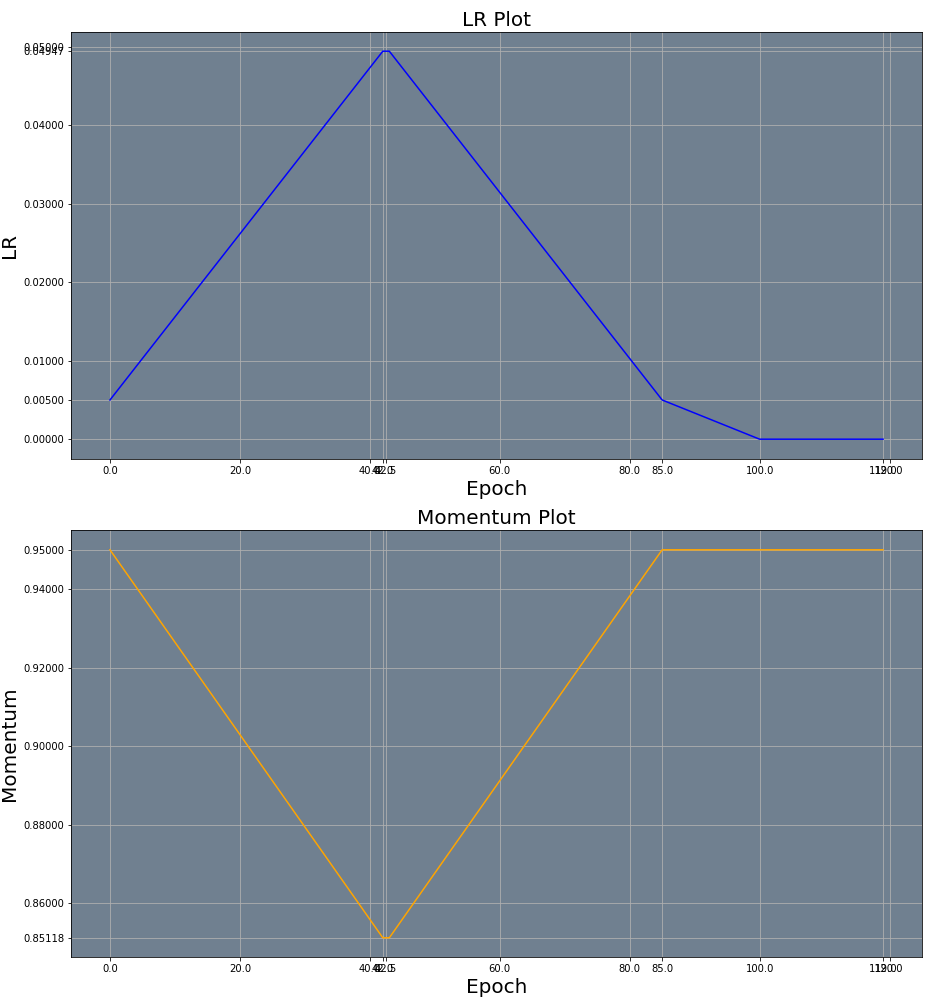

In [41]:
cycle_length = 85
total_epochs = 100

lr_policy = One_Cycle_Policy_LR(#optimizer=optim.SGD(net.parameters(), lr=5e-3, momentum=0.95, weight_decay=1e-4),
                                optimizer=optim.Adam(net.parameters(), lr=5e-3, betas=(0.95, 0.99), weight_decay=1e-2),
                                max_lr=5e-2, cycle_length=cycle_length, total_epochs=total_epochs,
                                gamma=0.98, const_lr=0.003, min_lr=0.0, lr_mode_after_cycle='linear',
                                min_momentum=0.85, cyclic_momentum=True, last_epoch=-1)

try:
    iterator = tqdm(iterable=range(max(total_epochs, cycle_length) + int(0.2 * max(total_epochs, cycle_length))),
                    desc="Epoch Iterations")
    %matplotlib notebook
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 14))
    axes[0].set_facecolor(plot_bg_color)
    axes[1].set_facecolor(plot_bg_color)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[0].set_title("LR Plot", fontsize=fontsize)
    axes[1].set_title("Momentum Plot", fontsize=fontsize)
    axes[0].set_xlabel("Epoch", fontsize=fontsize)
    axes[1].set_xlabel("Epoch", fontsize=fontsize)
    axes[0].set_ylabel("LR", fontsize=fontsize)
    axes[1].set_ylabel("Momentum", fontsize=fontsize)
    axes[0].plot([], [], color='blue')
    axes[1].plot([], [], color='orange')
    fig.tight_layout()
    
    epoch_list = []
    lr_list = []
    momentum_list = []
    
    for epoch in iterator:
        lr_policy.step()
        
        epoch_list.append(epoch)
        lr_list.append(lr_policy.get_lr()[0])
        momentum_list.append(lr_policy.get_momentum()[0])
        
        axes[0].lines[0].set_xdata(epoch_list)
        axes[1].lines[0].set_xdata(epoch_list)
        axes[0].lines[0].set_ydata(lr_list)
        axes[1].lines[0].set_ydata(momentum_list)
        
        max_min_diff = max(epoch_list) - min(epoch_list)
        if max_min_diff > 0:
            axes[0].set_xlim(min(epoch_list) - 0.05 * max_min_diff, max(epoch_list) + 0.05 * max_min_diff)
            axes[1].set_xlim(min(epoch_list) - 0.05 * max_min_diff, max(epoch_list) + 0.05 * max_min_diff)
        max_min_diff = max(lr_list) - min(lr_list)
        if max_min_diff > 0:
            axes[0].set_ylim(min(lr_list) - 0.05 * max_min_diff, max(lr_list) + 0.05 * max_min_diff)
        max_min_diff = max(momentum_list) - min(momentum_list)
        if max_min_diff > 0:
            axes[1].set_ylim(min(momentum_list) - 0.05 * max_min_diff, max(momentum_list) + 0.05 * max_min_diff)
        
        axes[0].xaxis.set_major_locator(AutoLocator())
        axes[0].yaxis.set_major_locator(AutoLocator())
        axes[1].xaxis.set_major_locator(AutoLocator())
        axes[1].yaxis.set_major_locator(AutoLocator())
        
        xlim = axes[0].get_xlim()
        xticks = [tick for tick in axes[0].get_xticks() if xlim[0] <= tick <= xlim[1]]
        for poi in (0, cycle_length/2, cycle_length, total_epochs, lr_list.index(min(lr_list)),
                    lr_list.index(max(lr_list)), epoch):
            if poi <= epoch and poi not in xticks:
                xticks.append(poi)
        axes[0].set_xticks(xticks)
        
        xlim = axes[1].get_xlim()
        xticks = [tick for tick in axes[1].get_xticks() if xlim[0] <= tick <= xlim[1]]
        for poi in (0, cycle_length/2, cycle_length, total_epochs, momentum_list.index(min(momentum_list)),
                    momentum_list.index(max(momentum_list)), epoch):
            if poi <= epoch and poi not in xticks:
                xticks.append(poi)
        axes[1].set_xticks(xticks)
        
        ylim = axes[0].get_ylim()
        yticks = [tick for tick in axes[0].get_yticks() if ylim[0] <= tick <= ylim[1]]
        if lr_list[0] not in yticks:
            yticks.append(lr_list[0])
        if min(lr_list) not in yticks:
            yticks.append(min(lr_list))
        if max(lr_list) not in yticks:
            yticks.append(max(lr_list))
        if lr_list[-1] not in yticks:
            yticks.append(lr_list[-1])
        if epoch >= (cycle_length // 2) and lr_list[cycle_length // 2] not in yticks:
            yticks.append(lr_list[cycle_length // 2])
        if epoch >= total_epochs and lr_list[total_epochs] not in yticks:
            yticks.append(lr_list[total_epochs])
        axes[0].set_yticks(yticks)
        
        ylim = axes[1].get_ylim()
        yticks = [tick for tick in axes[1].get_yticks() if ylim[0] <= tick <= ylim[1]]
        if momentum_list[0] not in yticks:
            yticks.append(momentum_list[0])
        if min(momentum_list) not in yticks:
            yticks.append(min(momentum_list))
        if max(momentum_list) not in yticks:
            yticks.append(max(momentum_list))
        if momentum_list[-1] not in yticks:
            yticks.append(momentum_list[-1])
        if epoch >= (cycle_length // 2) and momentum_list[cycle_length // 2] not in yticks:
            yticks.append(momentum_list[cycle_length // 2])
        if epoch >= total_epochs and momentum_list[total_epochs] not in yticks:
            yticks.append(momentum_list[total_epochs])
        axes[1].set_yticks(yticks)
        
        fig.canvas.draw()
        plt.pause(0.0001)
        
except BaseException as e:
    %matplotlib inline
    raise e
    
else:
    %matplotlib inline

---

## [#](#Final-Lab:-Classifying-flower-species) Finally, it's time to train the model!

In [45]:
def train(model, optimizer, criterion, n_epochs, device, train_loader, valid_loader, lr_schedule=None,
          prehistory=None, checkpoint_file_path=None, checkpoint_note=""):
    if not isinstance(optimizer, optim.Optimizer):
        raise TypeError('expected an optimizer for `optimizer`, but {} was given'.format(type(optimizer)))
    if not isinstance(n_epochs, int):
        raise TypeError('expected an int for `n_epochs`, but {} was given'.format(type(n_epochs)))
    if lr_schedule:
        if not isinstance(lr_schedule, lr_scheduler._LRScheduler):
            raise TypeError('expected a _LRScheduler for `lr_schedule`, but {} was given'.format(type(lr_schedule)))
    
    if prehistory:
        history = prehistory
        best_valid_loss = min(history['loss']['valid'])
        train_loss = history['loss']['train'][-1]
        train_acc = history['acc']['train'][-1]
        valid_loss = history['loss']['valid'][-1]
        valid_acc = history['acc']['valid'][-1]
        i_epoch = history['epoch'][-1] + 1
    else:
        history = {'epoch':[], 'loss': {'train':[], 'valid':[]}, 'acc': {'train':[], 'valid':[]}}
        best_valid_loss = np.inf
        train_loss = np.inf
        train_acc = 0.
        valid_loss = np.inf
        valid_acc = 0.
        i_epoch = 0
    
    def update_progress_stats(update_epoch, update_train, update_valid):
        if update_epoch:
            if 'momentum' in optimizer.param_groups[0]:
                momentum = optimizer.param_groups[0]['momentum']
            elif 'betas' in optimizer.param_groups[0]:
                momentum = optimizer.param_groups[0]['betas'][0]
            else:
                momentum = None
            if len(best_dict['history']['epoch']) > 0:
                epoch_iterator.set_postfix_str("current_epoch={}, "
                                               "train(loss={:.4f}, acc={:.3f}), "
                                               "valid(loss={:.4f}, acc={:.3f}), "
                                               "best_valid(epoch={}, loss={:.4f}, acc={:.3f}), "
                                               "lr={:.4e}, momentum={:.4f}"
                                               .format(0,
                                                       train_loss, train_acc,
                                                       valid_loss, valid_acc,
                                                       best_dict['history']['epoch'][-1],
                                                       best_dict['history']['loss']['valid'][-1],
                                                       best_dict['history']['acc']['valid'][-1],
                                                       Decimal(optimizer.param_groups[0]['lr']),
                                                       momentum),
                                               refresh=True)
            else:
                epoch_iterator.set_postfix_str("current_epoch={}, "
                                               "train(loss={:.4f}, acc={:.3f}), "
                                               "valid(loss={:.4f}, acc={:.3f}), "
                                               "best_valid(epoch={}, loss={:.4f}, acc={:.3f}), "
                                               "lr={:.4e}, momentum={:.4f}"
                                               .format(history['epoch'][-1] + 1,
                                                       train_loss, train_acc,
                                                       valid_loss, valid_acc,
                                                       -1,
                                                       np.inf,
                                                       0.,
                                                       Decimal(optimizer.param_groups[0]['lr']),
                                                       momentum),
                                               refresh=True)
        if update_train:
            train_iterator.set_postfix_str("loss={}, acc={}".format(loss.item(), corrects / inputs.size(0)), refresh=True)
        if update_valid:
            valid_iterator.set_postfix_str("loss={}, acc={}".format(loss.item(), corrects / inputs.size(0)), refresh=True)
    
    tracking_dict = {'history': history,
                     'model_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'lr_dict': lr_schedule.state_dict() if lr_schedule else None,
                     'note': checkpoint_note}
    
    best_dict = deepcopy(tracking_dict)
    
    if n_epochs < 1:
        return history, best_dict
    
    model.to(device)
    
    plot_on = False
    
    if lr_schedule:
        last_epoch = int(lr_schedule.last_epoch)
    
    try:
        epoch_iterator = tqdm(iterable=range(i_epoch, i_epoch + n_epochs), desc="Train Epochs")
        for epoch in epoch_iterator:
            if lr_schedule:
                last_epoch += 1
            
            update_progress_stats(True, False, False)
            
            model.train()
            running_loss = 0
            n_corrects = 0
            n_instances = 0
            train_iterator = tqdm(iterable=train_loader, desc="Train Iterations", leave=False)
            for i, (inputs, labels) in enumerate(train_iterator):
                if lr_schedule:
                    lr_schedule.step(last_epoch + (i / len(train_loader)))
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += (loss * inputs.size(0)).item()
                corrects = outputs.argmax(dim=1).eq(labels).sum().item()
                n_corrects += corrects
                n_instances += inputs.size(0)
                
                update_progress_stats(True, True, False)
                
            if lr_schedule:
                lr_schedule.last_epoch = last_epoch
            train_loss = running_loss / n_instances
            train_acc = n_corrects / n_instances
            
            update_progress_stats(True, False, False)

            model.eval()
            running_loss = 0
            n_corrects = 0
            n_instances = 0
            valid_iterator = tqdm(iterable=valid_loader, desc="Valid Iterations", leave=False)
            with torch.no_grad():
                for inputs, labels in valid_iterator:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += (loss * inputs.size(0)).item()
                    corrects = outputs.argmax(dim=1).eq(labels).sum().item()
                    n_corrects += corrects
                    n_instances += inputs.size(0)
                    update_progress_stats(True, False, True)
            valid_loss = running_loss / n_instances
            valid_acc = n_corrects / n_instances
            
            update_progress_stats(True, False, False)
            
            history['epoch'].append(epoch)
            history['loss']['train'].append(train_loss)
            history['acc']['train'].append(train_acc)
            history['loss']['valid'].append(valid_loss)
            history['acc']['valid'].append(valid_acc)
            if history['loss']['valid'][-1] < best_valid_loss:
                best_valid_loss = history['loss']['valid'][-1]
                tracking_dict = {'history': history,
                     'model_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'lr_dict': lr_schedule.state_dict() if lr_schedule else None,
                     'note': checkpoint_note}
                best_dict = deepcopy(tracking_dict)
                if checkpoint_file_path:
                    torch.save(best_dict, checkpoint_file_path)

            if epoch >= 1:
                if not plot_on:
                    %matplotlib notebook
                    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 24), facecolor=fig_bg_color)
                    axes[0].set_facecolor(plot_bg_color)
                    axes[0].grid(True)
                    axes[0].set_title("Training/Validation Loss", fontsize=fontsize)
                    axes[0].set_xlabel("Epoch", fontsize=fontsize)
                    axes[0].set_ylabel("Loss", fontsize=fontsize)
                    axes[0].plot([], [], color='blue', label='train loss')
                    axes[0].plot([], [], color='orange', label='valid loss')
                    axes[0].legend()
                    axes[1].set_facecolor(plot_bg_color)
                    axes[1].grid(True)
                    axes[1].set_title("Training/Validation Accuracy", fontsize=fontsize)
                    axes[1].set_xlabel("Epoch", fontsize=fontsize)
                    axes[1].set_ylabel("Accuracy", fontsize=fontsize)
                    axes[1].plot([], [], color='blue', label='train acc')
                    axes[1].plot([], [], color='orange', label='valid acc')
                    axes[1].legend()
                    fig.canvas.draw()
                    plot_on = True
                    
                axes[0].lines[0].set_xdata(history['epoch'])
                axes[0].lines[0].set_ydata(history['loss']['train'])
                axes[0].lines[1].set_xdata(history['epoch'])
                axes[0].lines[1].set_ydata(history['loss']['valid'])
                axes[1].lines[0].set_xdata(history['epoch'])
                axes[1].lines[0].set_ydata(history['acc']['train'])
                axes[1].lines[1].set_xdata(history['epoch'])
                axes[1].lines[1].set_ydata(history['acc']['valid'])

                axes[0].set_xlim(-0.05 * epoch, 1.05 * epoch)
                max_min_diff = (max(history['loss']['train'] + history['loss']['valid'])
                                - min(history['loss']['train'] + history['loss']['valid']))
                if max_min_diff > 0:
                    axes[0].set_ylim(min(history['loss']['train'] + history['loss']['valid']) - 0.05 * max_min_diff,
                                max(history['loss']['train'] + history['loss']['valid']) + 0.05 * max_min_diff)
                axes[1].set_xlim(-0.05 * epoch, 1.05 * epoch)
                max_min_diff = (max(history['acc']['train'] + history['acc']['valid'])
                                - min(history['acc']['train'] + history['acc']['valid']))
                if max_min_diff > 0:
                    axes[1].set_ylim(min(history['acc']['train'] + history['acc']['valid']) - 0.05 * max_min_diff,
                                max(history['acc']['train'] + history['acc']['valid']) + 0.05 * max_min_diff)

                axes[0].xaxis.set_major_locator(AutoLocator())
                axes[0].yaxis.set_major_locator(AutoLocator())
                axes[1].xaxis.set_major_locator(AutoLocator())
                axes[1].yaxis.set_major_locator(AutoLocator())

                xlim = axes[0].get_xlim()
                xticks = [tick for tick in axes[0].get_xticks() if xlim[0] <= tick <= xlim[1]]
                if history['loss']['train'].index(max(history['loss']['train'])) not in xticks:
                    xticks.append(history['loss']['train'].index(max(history['loss']['train'])))
                if history['loss']['train'].index(min(history['loss']['train'])) not in xticks:
                    xticks.append(history['loss']['train'].index(min(history['loss']['train'])))
                if history['loss']['valid'].index(max(history['loss']['valid'])) not in xticks:
                    xticks.append(history['loss']['valid'].index(max(history['loss']['valid'])))
                if history['loss']['valid'].index(best_valid_loss) not in xticks:
                    xticks.append(history['loss']['valid'].index(best_valid_loss))
                if epoch not in xticks:
                    xticks.append(epoch)
                axes[0].set_xticks(xticks)

                xlim = axes[1].get_xlim()
                xticks = [tick for tick in axes[1].get_xticks() if xlim[0] <= tick <= xlim[1]]
                if history['acc']['train'].index(max(history['acc']['train'])) not in xticks:
                    xticks.append(history['acc']['train'].index(max(history['acc']['train'])))
                if history['acc']['train'].index(min(history['acc']['train'])) not in xticks:
                    xticks.append(history['acc']['train'].index(min(history['acc']['train'])))
                if history['acc']['valid'].index(max(history['acc']['valid'])) not in xticks:
                    xticks.append(history['acc']['valid'].index(max(history['acc']['valid'])))
                if history['acc']['valid'].index(min(history['acc']['valid'])) not in xticks:
                    xticks.append(history['acc']['valid'].index(min(history['acc']['valid'])))
                if epoch not in xticks:
                    xticks.append(epoch)
                axes[1].set_xticks(xticks)

                ylim = axes[0].get_ylim()
                yticks = [tick for tick in axes[0].get_yticks() if ylim[0] <= tick <= ylim[1]]
                if max(history['loss']['train']) not in yticks:
                    yticks.append(max(history['loss']['train']))
                if min(history['loss']['train']) not in yticks:
                    yticks.append(min(history['loss']['train']))
                if max(history['loss']['valid']) not in yticks:
                    yticks.append(max(history['loss']['valid']))
                if best_valid_loss not in yticks:
                    yticks.append(best_valid_loss)
                if history['loss']['train'][-1] not in yticks:
                    yticks.append(history['loss']['train'][-1])
                if history['loss']['valid'][-1] not in yticks:
                    yticks.append(history['loss']['valid'][-1])
                axes[0].set_yticks(yticks)

                ylim = axes[1].get_ylim()
                yticks = [tick for tick in axes[1].get_yticks() if ylim[0] <= tick <= ylim[1]]
                if max(history['acc']['train']) not in yticks:
                    yticks.append(max(history['acc']['train']))
                if min(history['acc']['train']) not in yticks:
                    yticks.append(min(history['acc']['train']))
                if max(history['acc']['valid']) not in yticks:
                    yticks.append(max(history['acc']['valid']))
                if min(history['acc']['valid']) not in yticks:
                    yticks.append(min(history['acc']['valid']))
                if history['acc']['train'][-1] not in yticks:
                    yticks.append(history['acc']['train'][-1])
                if history['acc']['valid'][-1] not in yticks:
                    yticks.append(history['acc']['valid'][-1])
                axes[1].set_yticks(yticks)

                fig.canvas.draw()
                plt.pause(0.0001)
                
    except KeyboardInterrupt:
        if lr_schedule:
            lr_schedule.step(int(last_epoch))
    %matplotlib inline
    return history, best_dict

In [46]:
# Hyperparameters
batch_size = 26 # value tested in lr_find
n_epochs = 100
lr = 1.5e-5 / 10 # Best LR range divided by 10 (min_lr)
weight_decay = 1e-2 # value tested in lr_find
dropout = 0.0 # value tested in lr_find

train_loader.batch_sampler.batch_size = batch_size
valid_loader.batch_sampler.batch_size = batch_size
net.classifier.dropout.p = dropout
net.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.95, weight_decay=weight_decay)
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.95, 0.99), weight_decay=weight_decay)
lr_schedule = One_Cycle_Policy_LR(optimizer, max_lr=lr * 10, cycle_length=int(n_epochs * 0.85), total_epochs=n_epochs,
                                  cyclic_momentum=True)
# lr_schedule = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

note = ("Pretrained DenseNet169 with the last classifier layer replaced with my own, with 102 labels for this lab project.\n\n"
        "Cross Entropy was used as the criterion and SGD, Adam with momentum and weight decay was used as the optimizer.\n\n"
        "1Cycle Policy was implemented to control the lr and the momentum during the training.")

<IPython.core.display.Javascript object>


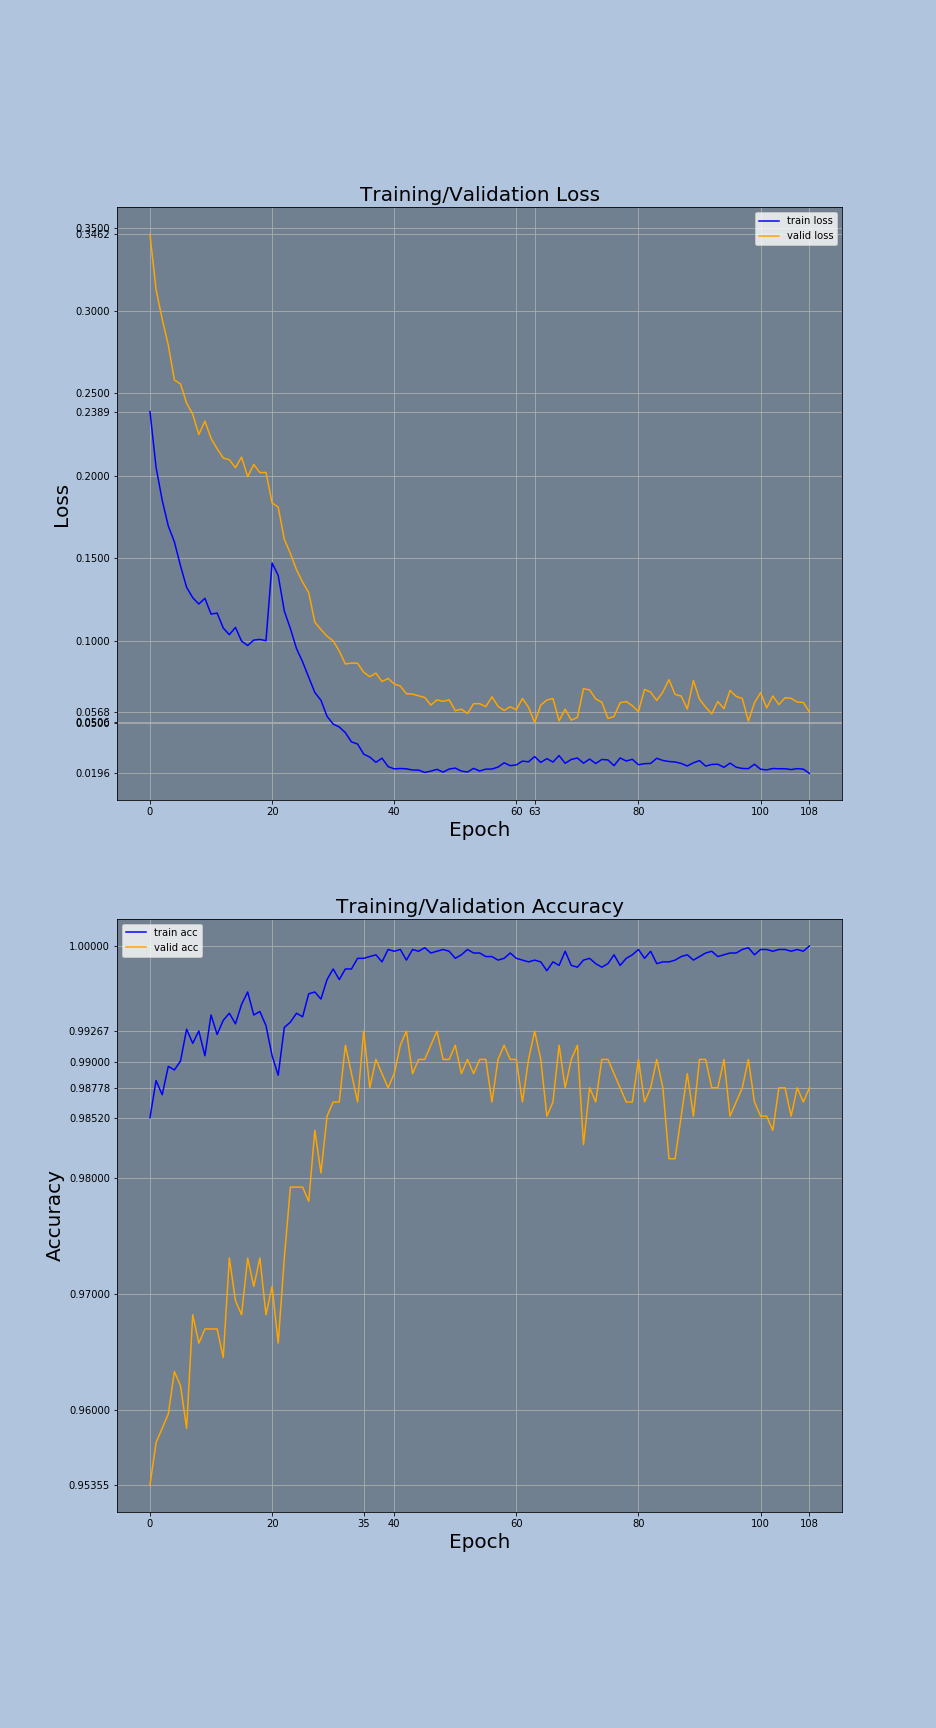

In [ ]:
history, best_dict = train(net, optimizer, criterion, n_epochs, device, train_loader, valid_loader,
                           prehistory=history, lr_schedule=lr_schedule,
                           checkpoint_file_path="./flower_densenet169_best.pt", checkpoint_note=note)

In [35]:
torch.save({'history': history, 'model_dict': net.state_dict(), 'optimizer_dict': optimizer.state_dict(),
            'lr_dict': lr_schedule.state_dict(), 'note': note},
           "./flower_densenet169.pt")

In [19]:
for param in net.parameters():
#     param.requires_grad_(False)
    param.requires_grad_(True)
# for param in net.features.denseblock4.parameters():
#     param.requires_grad_(True)

In [36]:
torch.cuda.empty_cache()

In [18]:
checkpoint = torch.load("./flower_densenet169_.pt", map_location=device)
history = checkpoint['history']
net.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
lr_schedule.load_state_dict(checkpoint['lr_dict'])
note = checkpoint['note']
print(note)

Pretrained DenseNet169 with the last classifier layer replaced with my own, with 102 labels for this lab project.

Cross Entropy was used as the criterion and SGD with momentum and weight decay was used as the optimizer.

1Cycle Policy was implemented to control the lr and the momentum during the training.


In [38]:
from deep_learning_flower_identifier_master.test_model_pytorch_facebook_challenge import calc_accuracy

In [41]:
calc_accuracy(net, input_image_size=224, testset_path='\\\\?\\' + os.path.abspath('./flower_data/flower_data_original_test/'),
              batch_size=32, norm_mean=train_means, norm_std=train_stds)

Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9473684430122375
Mean accuracy: 0.9763411283493042


0.9763411